In [21]:
import numpy as np
import pandas as pd
import datetime  

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.read_excel('/Users/evenbakke/Documents/Master Thesis/Predictions all models /All predictions .xlsx')
df.set_index("DateTime", inplace=True)
df.sort_index(ascending=True)
df

,MLP Prediction,LSTM Prediction,ARIMA Prediction,SARIMA Prediction,Daily Seasonal Naive,Weekly Seasonal Naive,Actual
DateTime,,,,,,,
2024-01-01 00:00:00,32.686039,37.331326,38.714075,39.681146,50.244588,25.525935,39.63
2024-01-01 01:00:00,30.060368,31.692480,38.955632,36.943204,47.024847,21.686652,35.36
2024-01-01 02:00:00,25.154123,34.805256,40.269223,35.067019,45.695916,19.966149,28.33
2024-01-01 03:00:00,19.856457,29.417273,42.113453,33.395415,43.676370,18.256374,24.48
2024-01-01 04:00:00,17.870594,25.771088,44.019731,33.427681,40.687281,17.937216,21.44
...,...,...,...,...,...,...,...
2024-05-31 19:00:00,50.688656,46.861507,37.284728,52.539678,53.600000,49.980000,47.84
2024-05-31 20:00:00,47.498726,47.162991,37.334601,51.997093,52.650000,43.380000,43.78
2024-05-31 21:00:00,43.672253,41.116447,37.380880,48.545518,49.310000,41.870000,39.95


In [23]:
df.columns

Index(['MLP Prediction', 'LSTM Prediction', 'ARIMA Prediction',
       'SARIMA Prediction', 'Daily Seasonal Naive', 'Weekly Seasonal Naive',
       'Actual'],
      dtype='object')

### Error metrics for all models: 

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_smape(predictions, actuals, epsilon=1e-10):
    return 100 * np.mean(2 * np.abs(predictions - actuals) / (np.abs(actuals) + np.abs(predictions) + epsilon))

def calculate_metrics(df, model_columns):
    metrics = []
    overall_metrics = {}

    # Ensure the DataFrame is sorted by DateTime index
    df = df.sort_index()

    grouped = df.groupby([df.index.year, df.index.month])

    # Initialize dictionaries to accumulate errors for overall metrics
    overall_errors = {model: {'squared_errors': [], 'absolute_errors': [], 'smape_values': []} for model in model_columns}

    for (year, month), group in grouped:
        month_metrics = {'Year': year, 'Month': month}
        actuals = group['Actual'].values

        for model in model_columns:
            predictions = group[model].values
            rmse = np.sqrt(mean_squared_error(actuals, predictions))
            mae = mean_absolute_error(actuals, predictions)
            smape = calculate_smape(predictions, actuals)

            month_metrics[f'{model} RMSE'] = rmse
            month_metrics[f'{model} MAE'] = mae
            month_metrics[f'{model} sMAPE'] = smape

            # Accumulate errors for overall metrics
            overall_errors[model]['squared_errors'].extend((actuals - predictions) ** 2)
            overall_errors[model]['absolute_errors'].extend(np.abs(actuals - predictions))
            overall_errors[model]['smape_values'].extend(2 * np.abs(actuals - predictions) / (np.abs(actuals) + np.abs(predictions) + 1e-10))

        metrics.append(month_metrics)

    # Calculate overall metrics
    for model in model_columns:
        overall_rmse = np.sqrt(np.mean(overall_errors[model]['squared_errors']))
        overall_mae = np.mean(overall_errors[model]['absolute_errors'])
        overall_smape = 100 * np.mean(overall_errors[model]['smape_values'])

        overall_metrics[f'{model} RMSE'] = overall_rmse
        overall_metrics[f'{model} MAE'] = overall_mae
        overall_metrics[f'{model} sMAPE'] = overall_smape

    return pd.DataFrame(metrics), overall_metrics

model_columns = ['MLP Prediction', 'LSTM Prediction', 'ARIMA Prediction', 'SARIMA Prediction','Daily Seasonal Naive', 'Weekly Seasonal Naive']
monthly_metrics, overall_metrics = calculate_metrics(df, model_columns)


print("Monthly Metrics:")
print(monthly_metrics)

print("\nOverall Metrics:")
for model, metrics in overall_metrics.items():
    print(f'{model}: {metrics}')


Monthly Metrics:
   Year  Month  MLP Prediction RMSE  MLP Prediction MAE  MLP Prediction sMAPE  \
0  2024      1             5.477434            3.445489              5.568921   
1  2024      2             3.512235            2.492973              8.897709   
2  2024      3             3.206616            2.114022              4.083735   
3  2024      4             4.830835            3.580535             17.353848   
4  2024      5             5.001272            4.105886             36.028580   

   LSTM Prediction RMSE  LSTM Prediction MAE  LSTM Prediction sMAPE  \
0              7.164190             4.370772               7.218589   
1              5.843612             4.427531              12.180157   
2              6.926186             5.091966               9.567093   
3              6.956578             4.925768              20.685185   
4              6.472547             4.905255              37.336774   

   ARIMA Prediction RMSE  ARIMA Prediction MAE  ARIMA Prediction sMAP

# Diebold-Mariano test

Comparing MLP Prediction and LSTM Prediction:
  Diebold–Mariano Test Statistic: -11.811296668740082
  p-value: 3.4125735866367935e-32
  The MLP Prediction model performs significantly better than the LSTM Prediction model.


Comparing MLP Prediction and ARIMA Prediction:
  Diebold–Mariano Test Statistic: -20.23047397554775
  p-value: 5.279306676056841e-91
  The MLP Prediction model performs significantly better than the ARIMA Prediction model.


Comparing MLP Prediction and SARIMA Prediction:
  Diebold–Mariano Test Statistic: -24.010787831600744
  p-value: 2.1453849386493355e-127
  The MLP Prediction model performs significantly better than the SARIMA Prediction model.


Comparing MLP Prediction and Daily Seasonal Naive:
  Diebold–Mariano Test Statistic: -24.002677328774617
  p-value: 2.6074229231397753e-127
  The MLP Prediction model performs significantly better than the Daily Seasonal Naive model.


Comparing MLP Prediction and Weekly Seasonal Naive:
  Diebold–Mariano Test Statistic

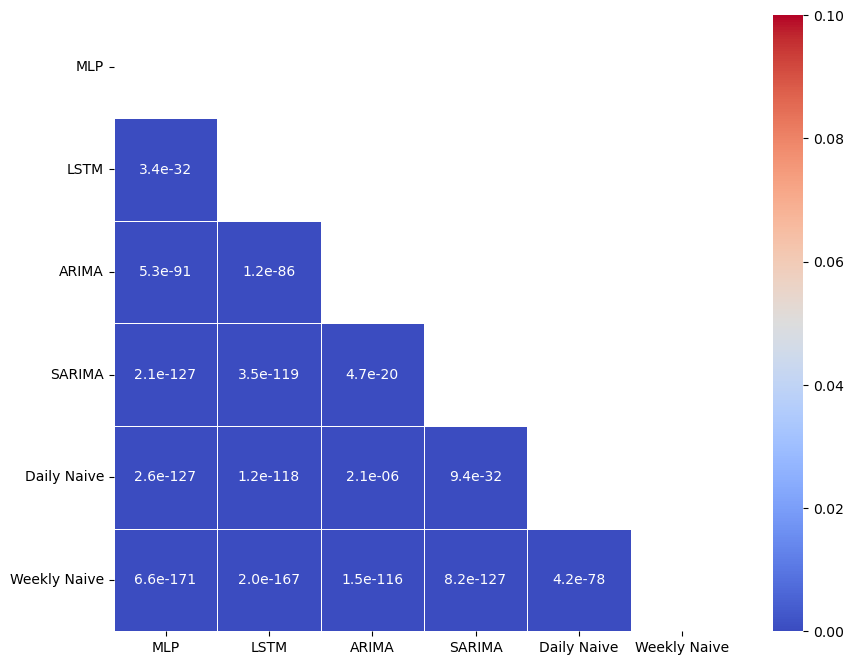

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

models = ['MLP Prediction', 'LSTM Prediction', 'ARIMA Prediction', 
          'SARIMA Prediction', 'Daily Seasonal Naive', 'Weekly Seasonal Naive']

model_display_names = ['MLP', 'LSTM', 'ARIMA', 'SARIMA', 'Daily Naive', 'Weekly Naive']

# Calculate forecast errors for each model
for model in models:
    df[f'Error_{model}'] = df['Actual'] - df[model]

# Calculate the squared errors (MSE for each time point)
for model in models:
    df[f'MSE_{model}'] = df[f'Error_{model}'] ** 2

# Function to calculate the Diebold–Mariano test statistic for a two-sided test
def diebold_mariano_test(loss_diff):
    mean_d = np.mean(loss_diff)
    var_d = np.var(loss_diff, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(loss_diff))
    p_value = 2 * norm.cdf(-abs(dm_stat))
    return dm_stat, p_value

# Create a list to store results
dm_results = []

# Generate all pairs of models
model_pairs = list(combinations(models, 2))

# Compute the loss differentials for each pair of models
for model_a, model_b in model_pairs:
    df[f'Loss_Diff_{model_a}_{model_b}'] = df[f'MSE_{model_a}'] - df[f'MSE_{model_b}']

# Perform DM test for each pair of models and print results
for model_a, model_b in model_pairs:
    loss_diff = df[f'Loss_Diff_{model_a}_{model_b}'].values
    dm_stat, p_value = diebold_mariano_test(loss_diff)
    dm_results.append({'Model_A': model_a, 'Model_B': model_b, 'DM_Stat': dm_stat, 'P_Value': p_value})
    
    # Print the results of the DM test
    print(f"Comparing {model_a} and {model_b}:")
    print(f"  Diebold–Mariano Test Statistic: {dm_stat}")
    print(f"  p-value: {p_value}")
    if p_value < 0.05:
        if dm_stat < 0:
            print(f"  The {model_a} model performs significantly better than the {model_b} model.")
        else:
            print(f"  The {model_b} model performs significantly better than the {model_a} model.")
    else:
        print("  The difference in forecast accuracy between the two models is not statistically significant.")
    print("\n")


dm_results_df = pd.DataFrame(dm_results)

dm_pivot = dm_results_df.pivot(index='Model_A', columns='Model_B', values='P_Value')

dm_matrix = pd.DataFrame(np.nan, index=models, columns=models)

for i, row in dm_pivot.iterrows():
    for col in dm_pivot.columns:
        dm_matrix.loc[i, col] = dm_pivot.loc[i, col]

for i in range(dm_matrix.shape[0]):
    for j in range(i, dm_matrix.shape[1]):
        dm_matrix.iloc[j, i] = dm_matrix.iloc[i, j]

# Rename the index and columns for display
dm_matrix.index = model_display_names
dm_matrix.columns = model_display_names

mask = np.triu(np.ones_like(dm_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(dm_matrix, mask=mask, annot=True, fmt=".1e", cmap="coolwarm", linewidths=.5, vmin=0, vmax=0.10)
plt.xticks(rotation=0)  
plt.yticks(rotation=0)  
plt.show()


# Analysis of results

/var/folders/f_/j_mdbrm574j13dk_c3yb57xm0000gn/T/ipykernel_6031/1966166074.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_rmse_mlp = df.groupby('Hour').apply(lambda x: np.sqrt(((x['Actual'] - x['MLP Prediction']) ** 2).mean()))
/var/folders/f_/j_mdbrm574j13dk_c3yb57xm0000gn/T/ipykernel_6031/1966166074.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_rmse_lstm = df.groupby('Hour').appl

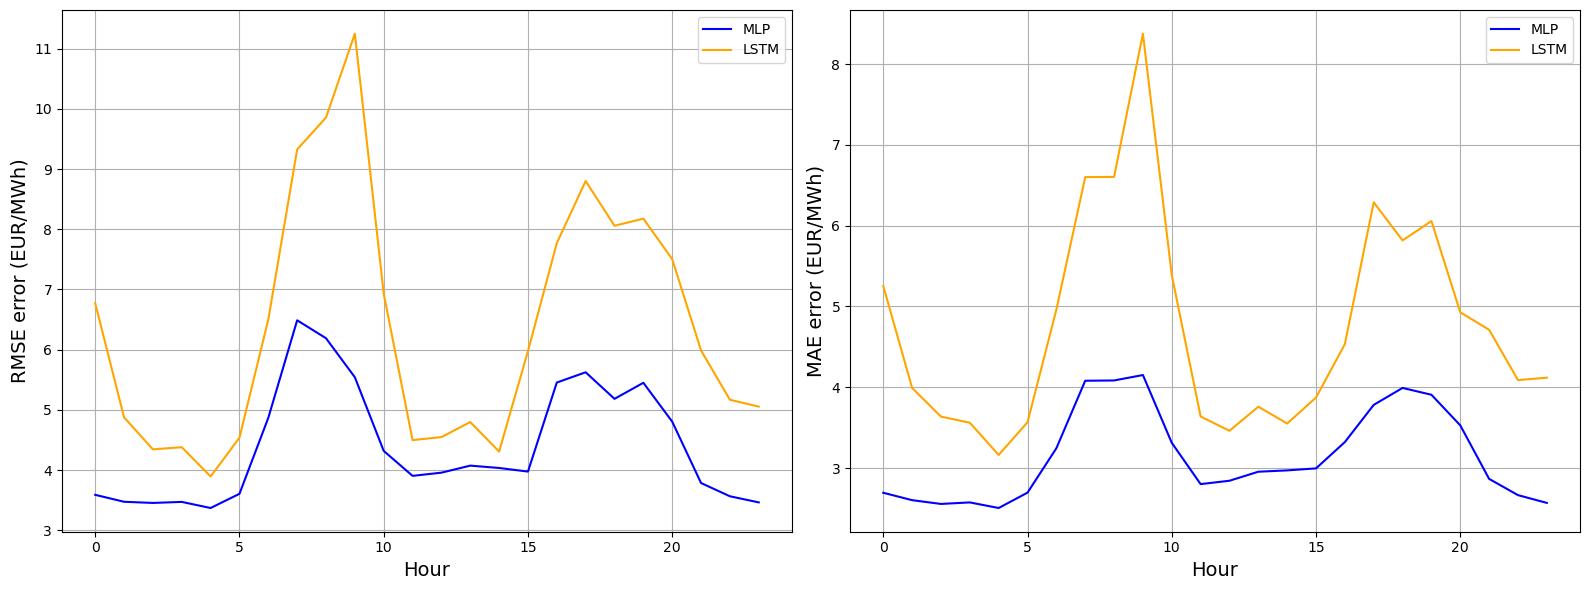

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df.index = pd.to_datetime(df.index)

df['Hour'] = df.index.hour

hourly_rmse_mlp = df.groupby('Hour').apply(lambda x: np.sqrt(((x['Actual'] - x['MLP Prediction']) ** 2).mean()))
hourly_rmse_lstm = df.groupby('Hour').apply(lambda x: np.sqrt(((x['Actual'] - x['LSTM Prediction']) ** 2).mean()))

hourly_mae_mlp = df.groupby('Hour').apply(lambda x: np.mean(np.abs(x['Actual'] - x['MLP Prediction'])))
hourly_mae_lstm = df.groupby('Hour').apply(lambda x: np.mean(np.abs(x['Actual'] - x['LSTM Prediction'])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(hourly_rmse_mlp.index, hourly_rmse_mlp, linestyle='-', label='MLP', color='blue')
ax1.plot(hourly_rmse_lstm.index, hourly_rmse_lstm, linestyle='-', label='LSTM', color='orange')
ax1.set_xlabel('Hour', fontsize=14)
ax1.set_ylabel('RMSE error (EUR/MWh)', fontsize=14)
ax1.legend()
ax1.grid(True)


ax2.plot(hourly_mae_mlp.index, hourly_mae_mlp, linestyle='-', label='MLP', color='blue')
ax2.plot(hourly_mae_lstm.index, hourly_mae_lstm, linestyle='-', label='LSTM', color='orange')
ax2.set_xlabel('Hour', fontsize=14)
ax2.set_ylabel('MAE error (EUR/MWh)', fontsize=14)
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()


/var/folders/f_/j_mdbrm574j13dk_c3yb57xm0000gn/T/ipykernel_6031/2654924660.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekday_rmse_mlp = df.groupby('Weekday').apply(lambda x: np.sqrt(((x['Actual'] - x['MLP Prediction']) ** 2).mean()))
/var/folders/f_/j_mdbrm574j13dk_c3yb57xm0000gn/T/ipykernel_6031/2654924660.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekday_rmse_lstm = df.groupby('Weekd

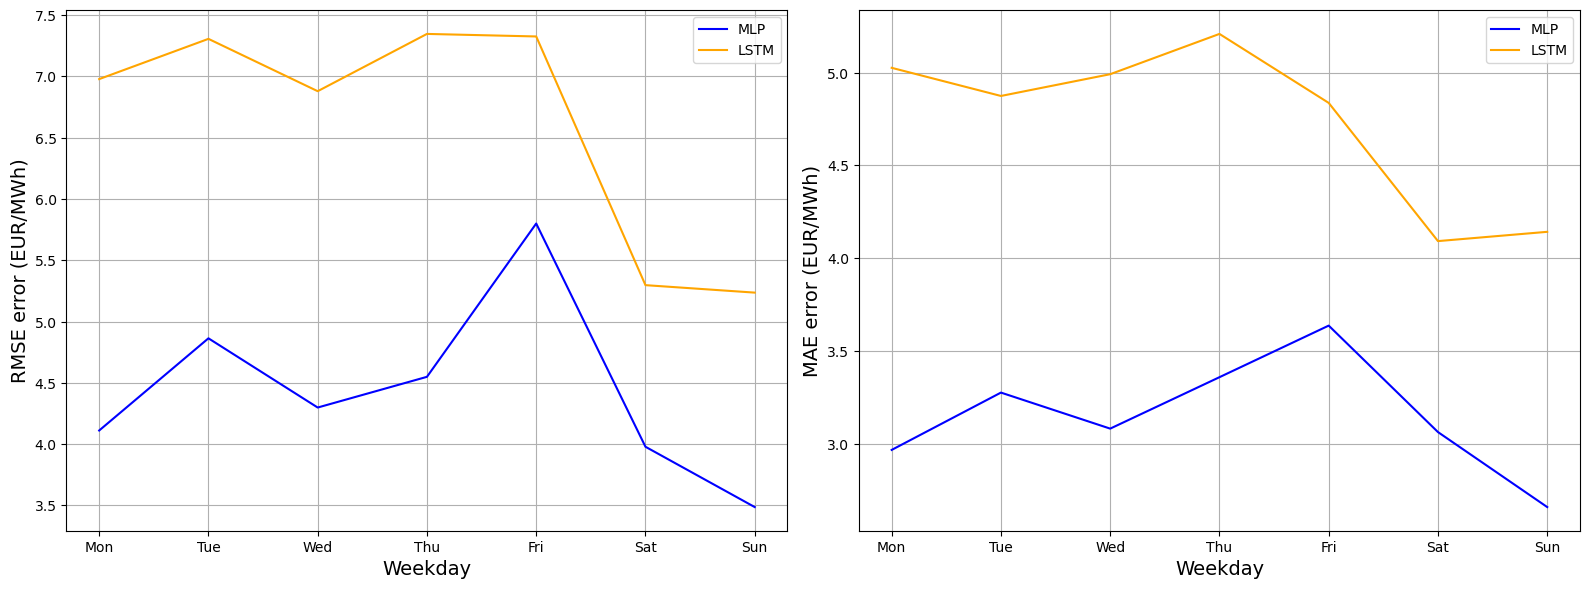

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df.index = pd.to_datetime(df.index)

# Extract weekday (0=Monday, 6=Sunday)
df['Weekday'] = df.index.weekday

# Calculate RMSE for each weekday for MLP and LSTM
weekday_rmse_mlp = df.groupby('Weekday').apply(lambda x: np.sqrt(((x['Actual'] - x['MLP Prediction']) ** 2).mean()))
weekday_rmse_lstm = df.groupby('Weekday').apply(lambda x: np.sqrt(((x['Actual'] - x['LSTM Prediction']) ** 2).mean()))

# Calculate MAE for each weekday for MLP and LSTM
weekday_mae_mlp = df.groupby('Weekday').apply(lambda x: np.mean(np.abs(x['Actual'] - x['MLP Prediction'])))
weekday_mae_lstm = df.groupby('Weekday').apply(lambda x: np.mean(np.abs(x['Actual'] - x['LSTM Prediction'])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(weekday_rmse_mlp.index, weekday_rmse_mlp, linestyle='-', label='MLP', color='blue')
ax1.plot(weekday_rmse_lstm.index, weekday_rmse_lstm, linestyle='-', label='LSTM', color='orange')
ax1.set_xlabel('Weekday', fontsize=14)
ax1.set_ylabel('RMSE error (EUR/MWh)', fontsize=14)
ax1.set_xticks(range(7))
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.legend()
ax1.grid(True)

ax2.plot(weekday_mae_mlp.index, weekday_mae_mlp, linestyle='-', label='MLP', color='blue')
ax2.plot(weekday_mae_lstm.index, weekday_mae_lstm, linestyle='-', label='LSTM', color='orange')
ax2.set_xlabel('Weekday', fontsize=14)
ax2.set_ylabel('MAE error (EUR/MWh)', fontsize=14)
ax2.set_xticks(range(7))
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()


/var/folders/f_/j_mdbrm574j13dk_c3yb57xm0000gn/T/ipykernel_6031/3872899439.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse_mlp = df.groupby('Month').apply(lambda x: np.sqrt(((x['Actual'] - x['MLP Prediction']) ** 2).mean()))
/var/folders/f_/j_mdbrm574j13dk_c3yb57xm0000gn/T/ipykernel_6031/3872899439.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse_lstm = df.groupby('Month')

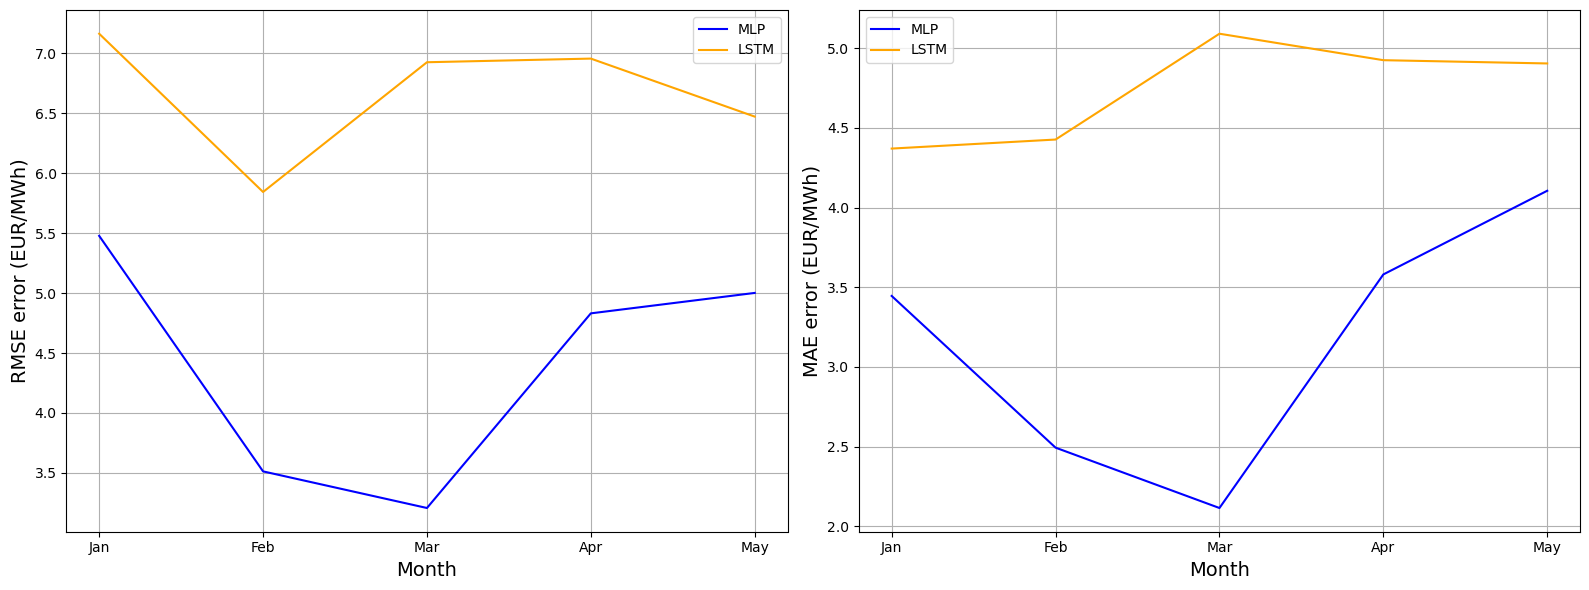

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df.index = pd.to_datetime(df.index)

# Extract month (1=January, 12=December)
df['Month'] = df.index.month

# Calculate RMSE for each month for MLP and LSTM
monthly_rmse_mlp = df.groupby('Month').apply(lambda x: np.sqrt(((x['Actual'] - x['MLP Prediction']) ** 2).mean()))
monthly_rmse_lstm = df.groupby('Month').apply(lambda x: np.sqrt(((x['Actual'] - x['LSTM Prediction']) ** 2).mean()))

# Calculate MAE for each month for MLP and LSTM
monthly_mae_mlp = df.groupby('Month').apply(lambda x: np.mean(np.abs(x['Actual'] - x['MLP Prediction'])))
monthly_mae_lstm = df.groupby('Month').apply(lambda x: np.mean(np.abs(x['Actual'] - x['LSTM Prediction'])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(monthly_rmse_mlp.index, monthly_rmse_mlp, linestyle='-', label='MLP', color='blue')
ax1.plot(monthly_rmse_lstm.index, monthly_rmse_lstm, linestyle='-', label='LSTM', color='orange')
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('RMSE error (EUR/MWh)', fontsize=14)
ax1.set_xticks(range(1, 6))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May'])
ax1.legend()
ax1.grid(True)

ax2.plot(monthly_mae_mlp.index, monthly_mae_mlp, linestyle='-', label='MLP', color='blue')
ax2.plot(monthly_mae_lstm.index, monthly_mae_lstm, linestyle='-', label='LSTM', color='orange')
ax2.set_xlabel('Month', fontsize=14)
ax2.set_ylabel('MAE error (EUR/MWh)', fontsize=14)
ax2.set_xticks(range(1, 6))
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May'])
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()


### Plotting predictions from MLP and LSTM vs Actuals

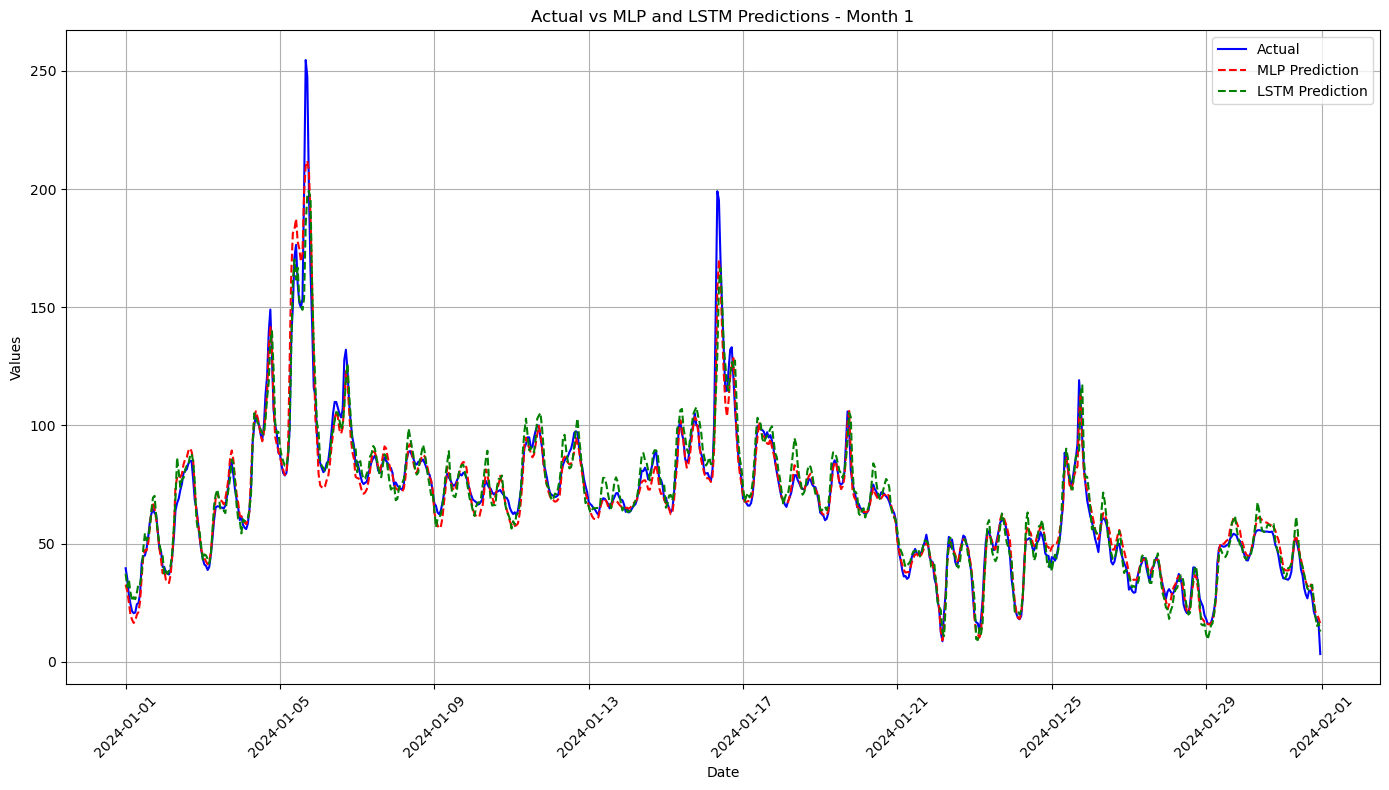

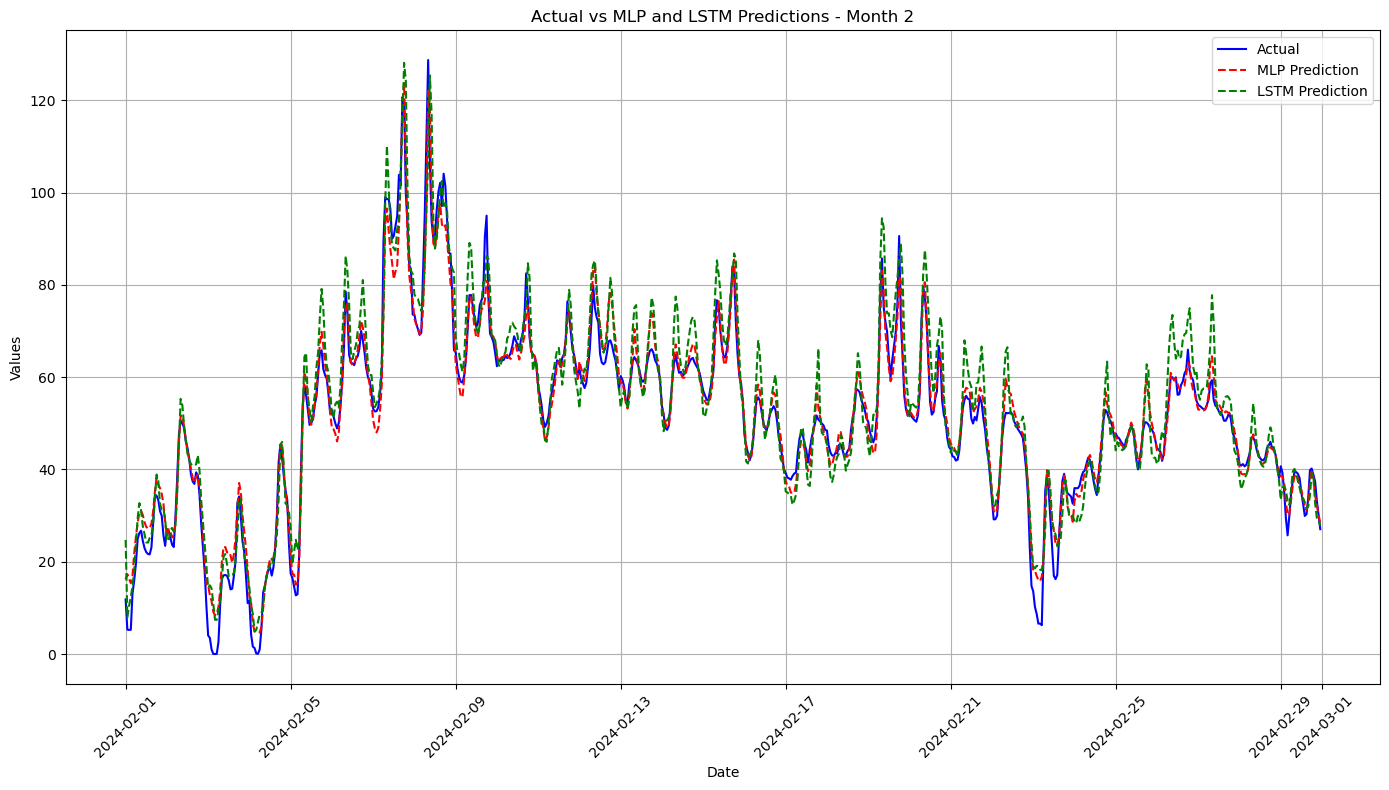

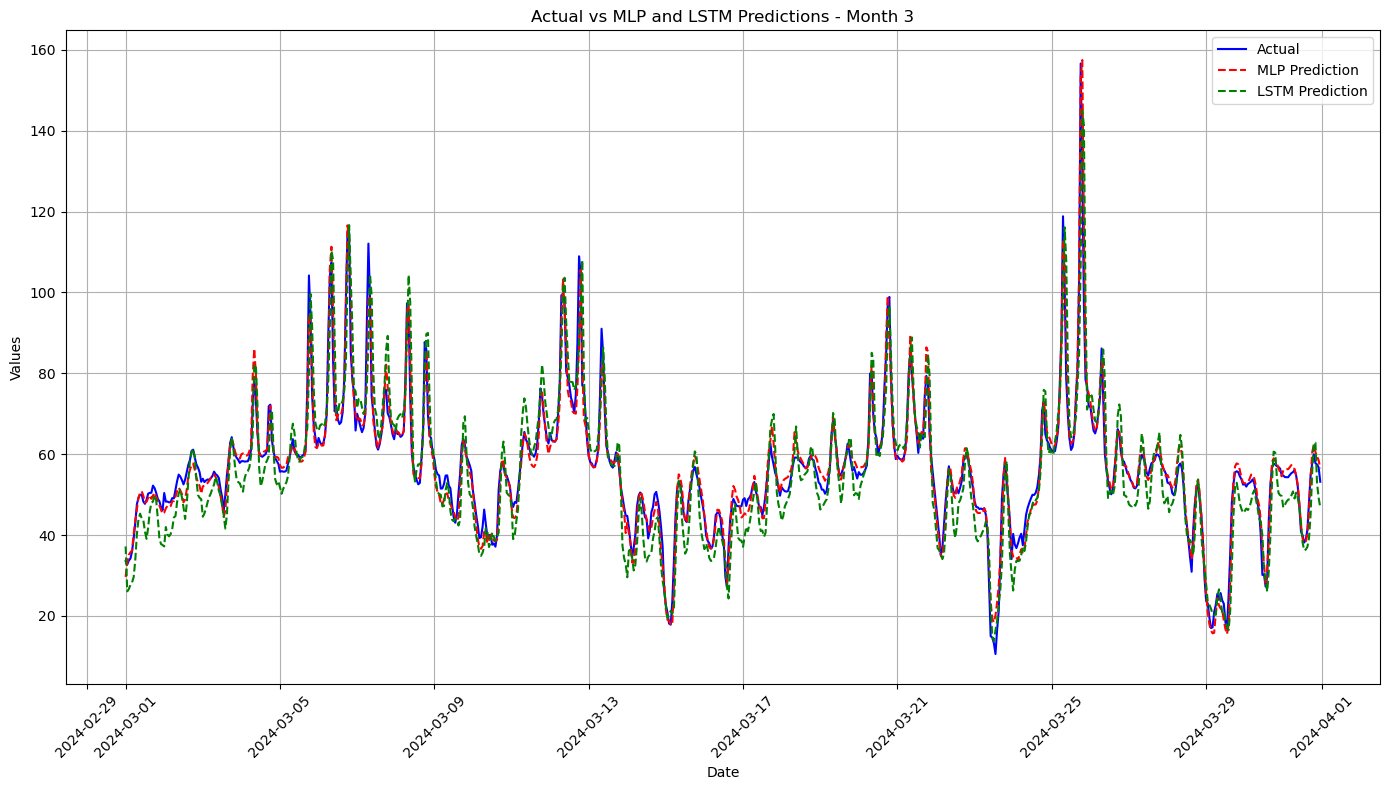

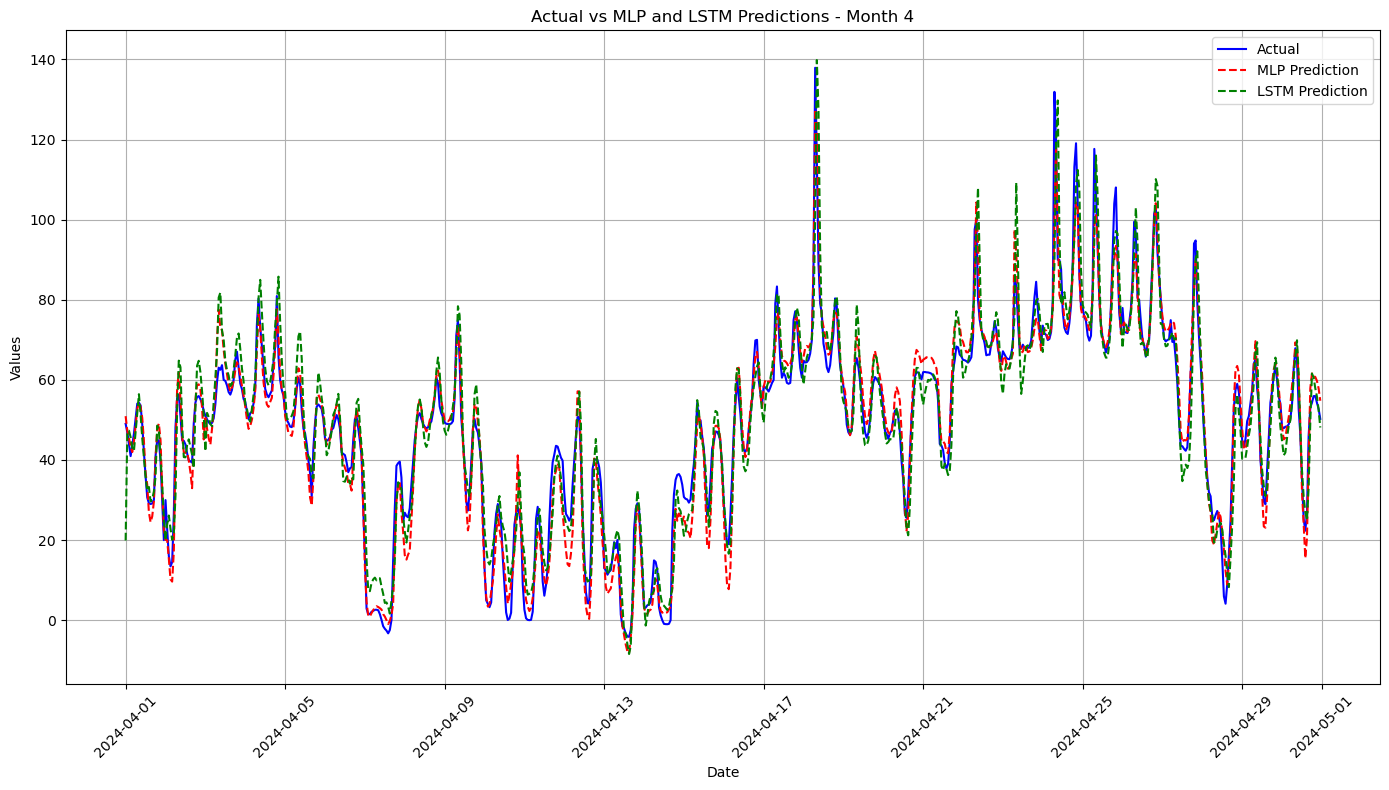

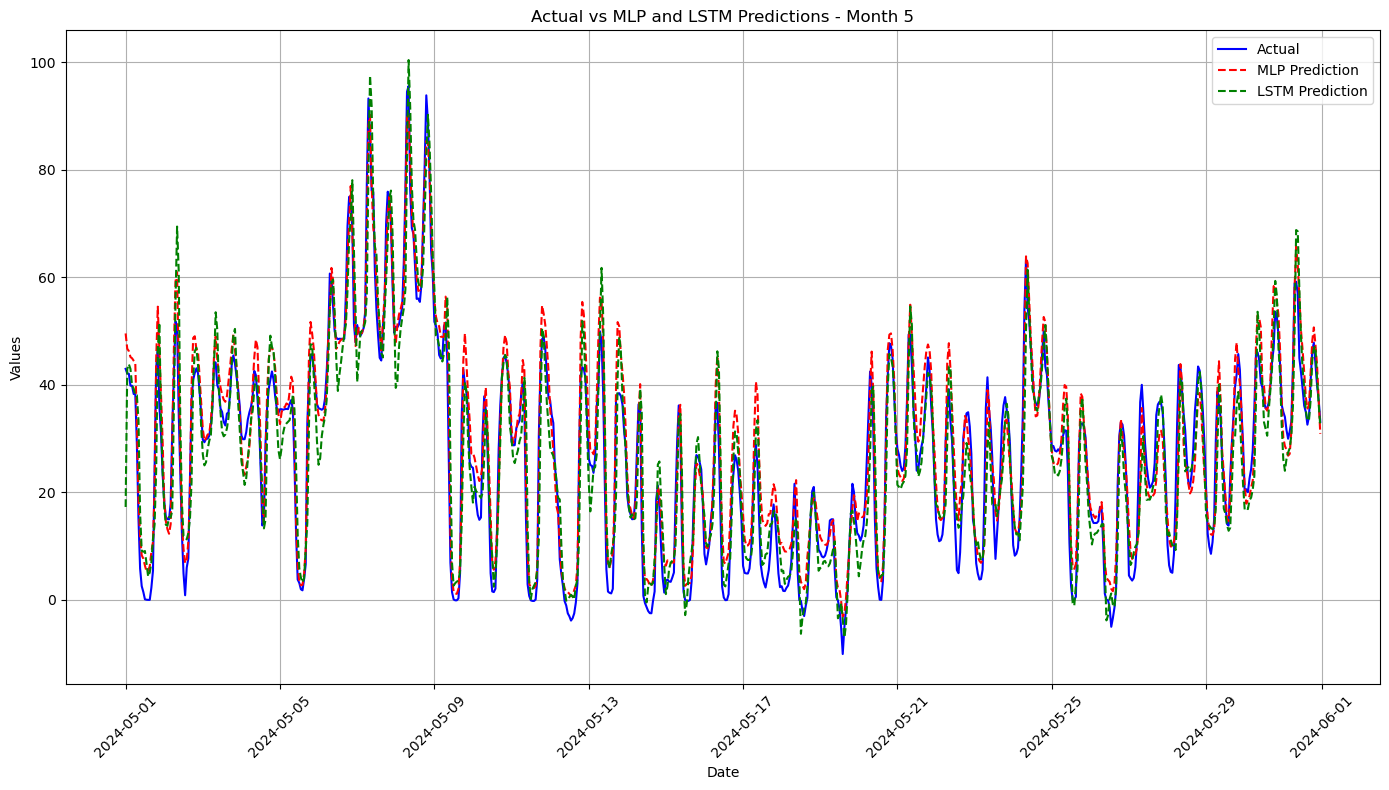

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Loop through the first five months
for month in [1, 2, 3, 4, 5]:
    # Filter data for the specific month
    df_month = df[df.index.month == month]
    
    # Create a plot for the current month
    plt.figure(figsize=(14, 8))
    
    plt.plot(df_month.index, df_month['Actual'], label='Actual', color='blue', linewidth=1.5)
    
    plt.plot(df_month.index, df_month['MLP Prediction'], label='MLP Prediction', color='red', linestyle='--', linewidth=1.5)
    
    plt.plot(df_month.index, df_month['LSTM Prediction'], label='LSTM Prediction', color='green', linestyle='--', linewidth=1.5)
    
    plt.title(f'Actual vs MLP and LSTM Predictions - Month {month}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()


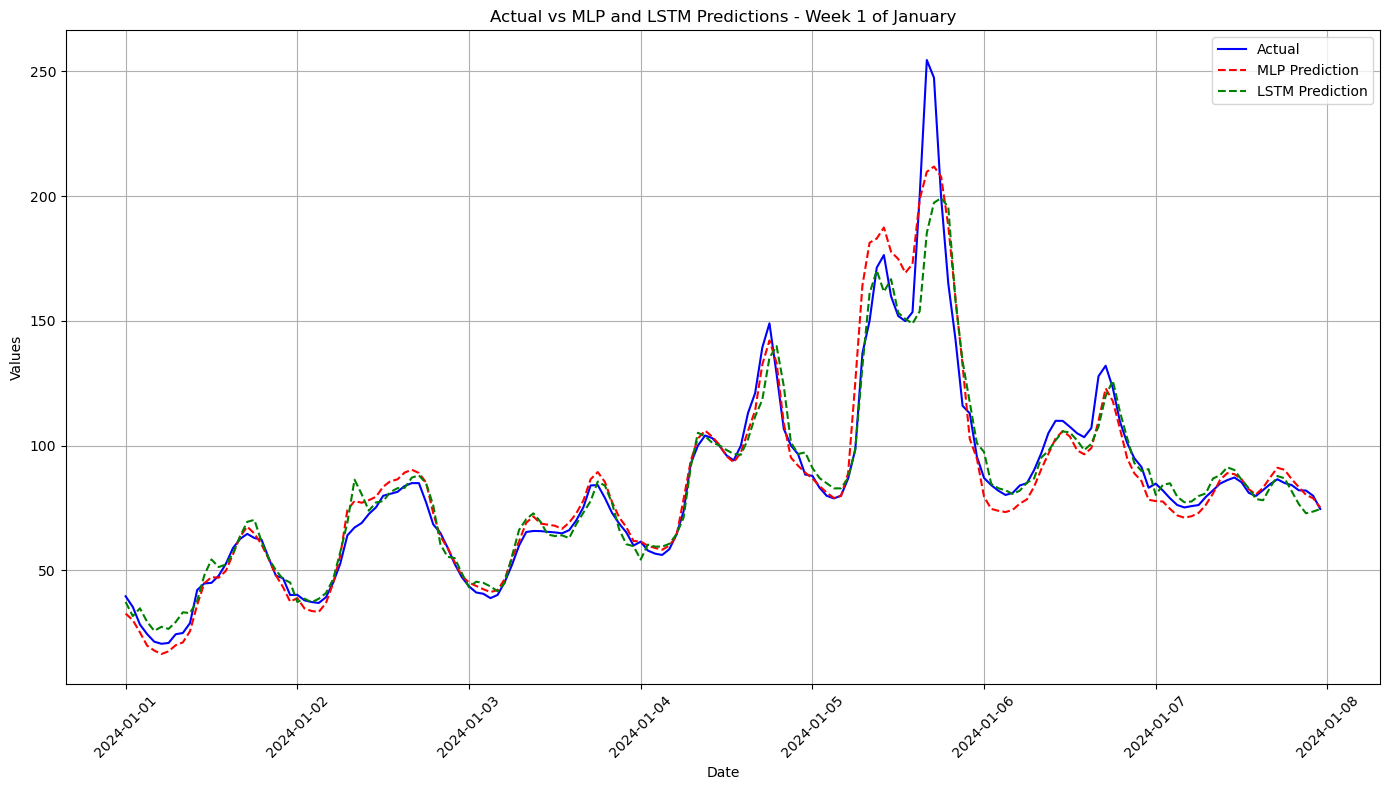

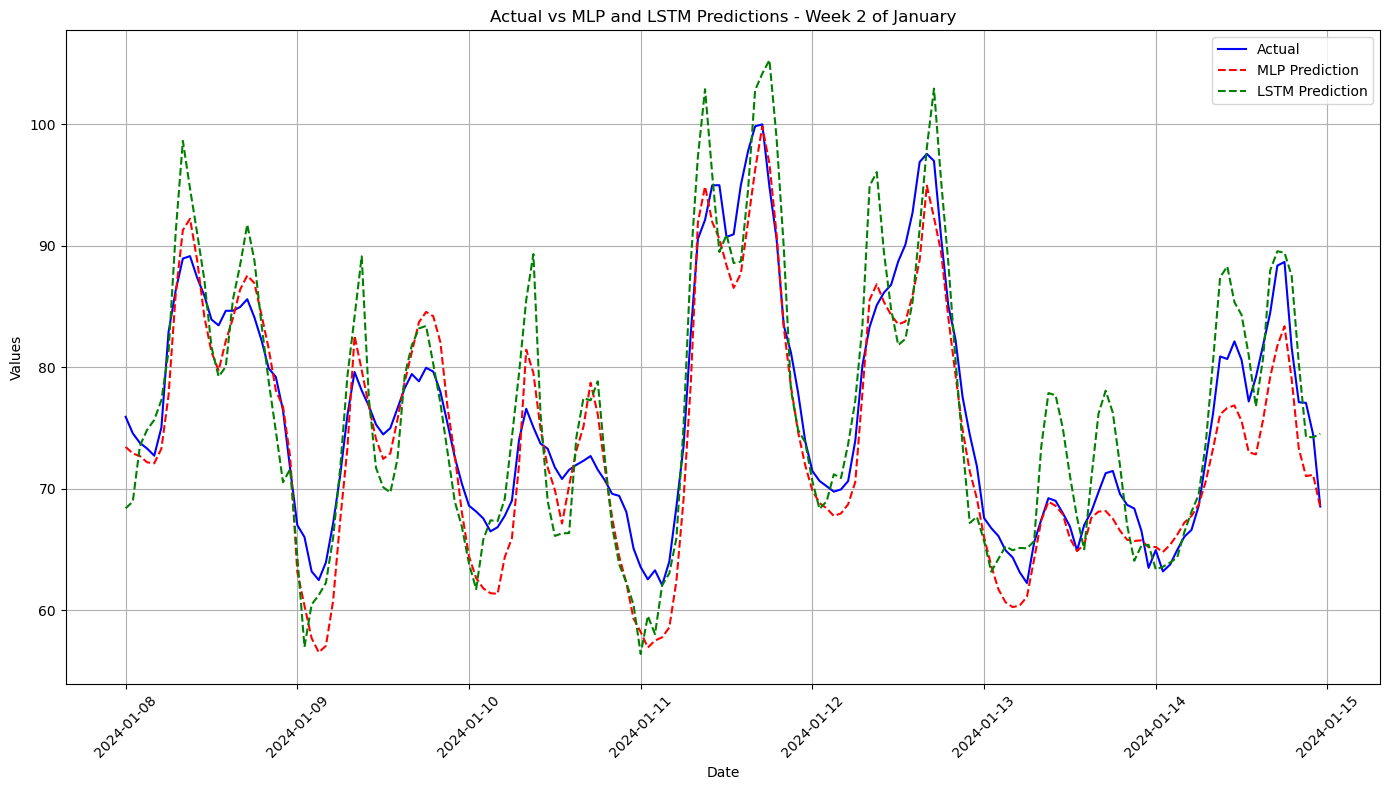

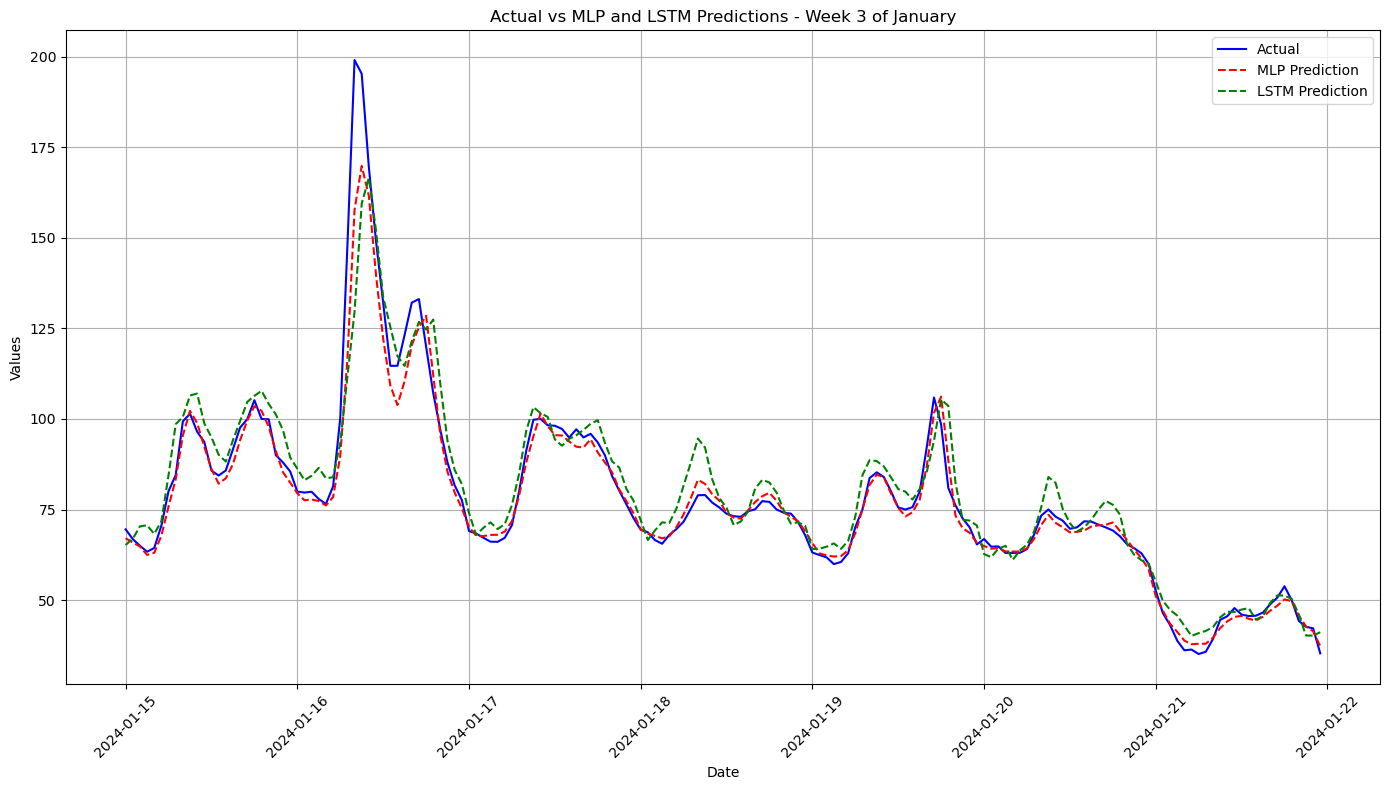

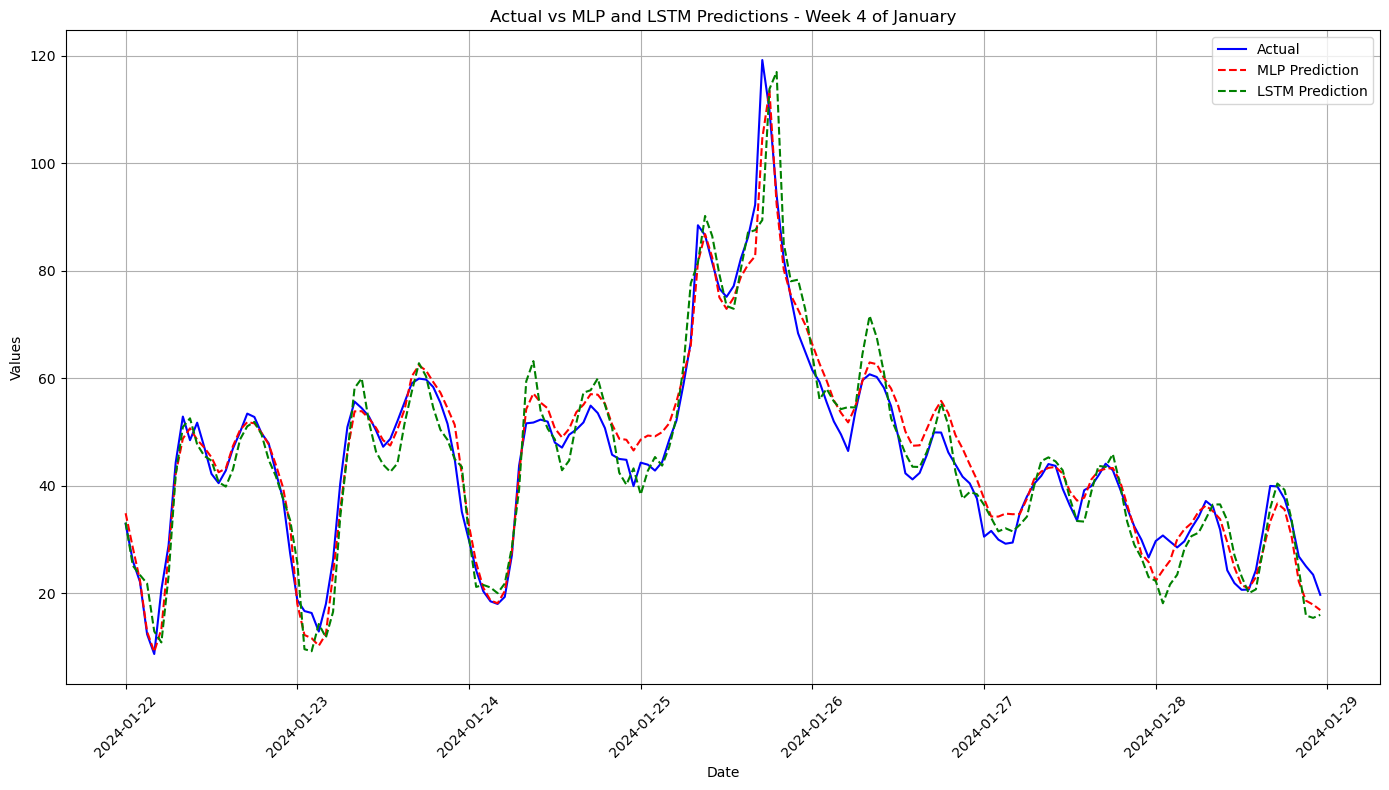

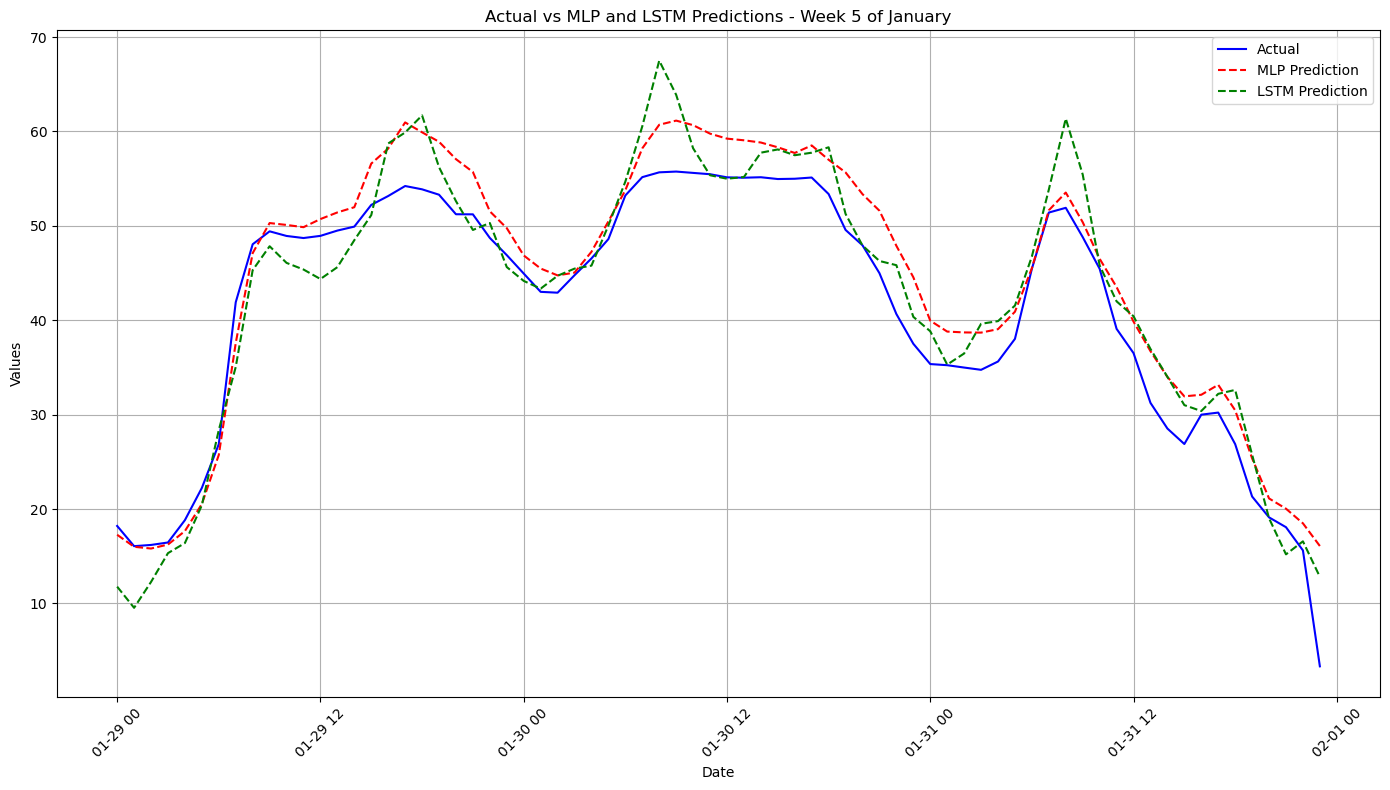

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df_january = df[df.index.month == 1]

for week in df_january.index.isocalendar().week.unique():

    df_week = df_january[df_january.index.isocalendar().week == week]
    
    plt.figure(figsize=(14, 8))
    
    plt.plot(df_week.index, df_week['Actual'], label='Actual', color='blue', linewidth=1.5)
    
    plt.plot(df_week.index, df_week['MLP Prediction'], label='MLP Prediction', color='red', linestyle='--', linewidth=1.5)
    
    plt.plot(df_week.index, df_week['LSTM Prediction'], label='LSTM Prediction', color='green', linestyle='--', linewidth=1.5)
    
    plt.title(f'Actual vs MLP and LSTM Predictions - Week {week} of January')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    

    plt.show()


### Predictions overestimation/underestimation

In [25]:

over_under_results = {
    'Model': [],
    'Overestimate (%)': [],
    'Underestimate (%)': []
}

models_to_investigate = ['MLP Prediction', 'LSTM Prediction']

for model in models_to_investigate:
    overestimates = (df[model] > df['Actual']).sum()
    underestimates = (df[model] < df['Actual']).sum()
    total_predictions = len(df)

    overestimate_percentage = (overestimates / total_predictions) * 100
    underestimate_percentage = (underestimates / total_predictions) * 100

    over_under_results['Model'].append(model)
    over_under_results['Overestimate (%)'].append(overestimate_percentage)
    over_under_results['Underestimate (%)'].append(underestimate_percentage)

over_under_df = pd.DataFrame(over_under_results)
print(over_under_df)


             Model  Overestimate (%)  Underestimate (%)
0   MLP Prediction         55.838816          44.161184
1  LSTM Prediction         53.152412          46.847588


### Flagging positive and negative price spikes 

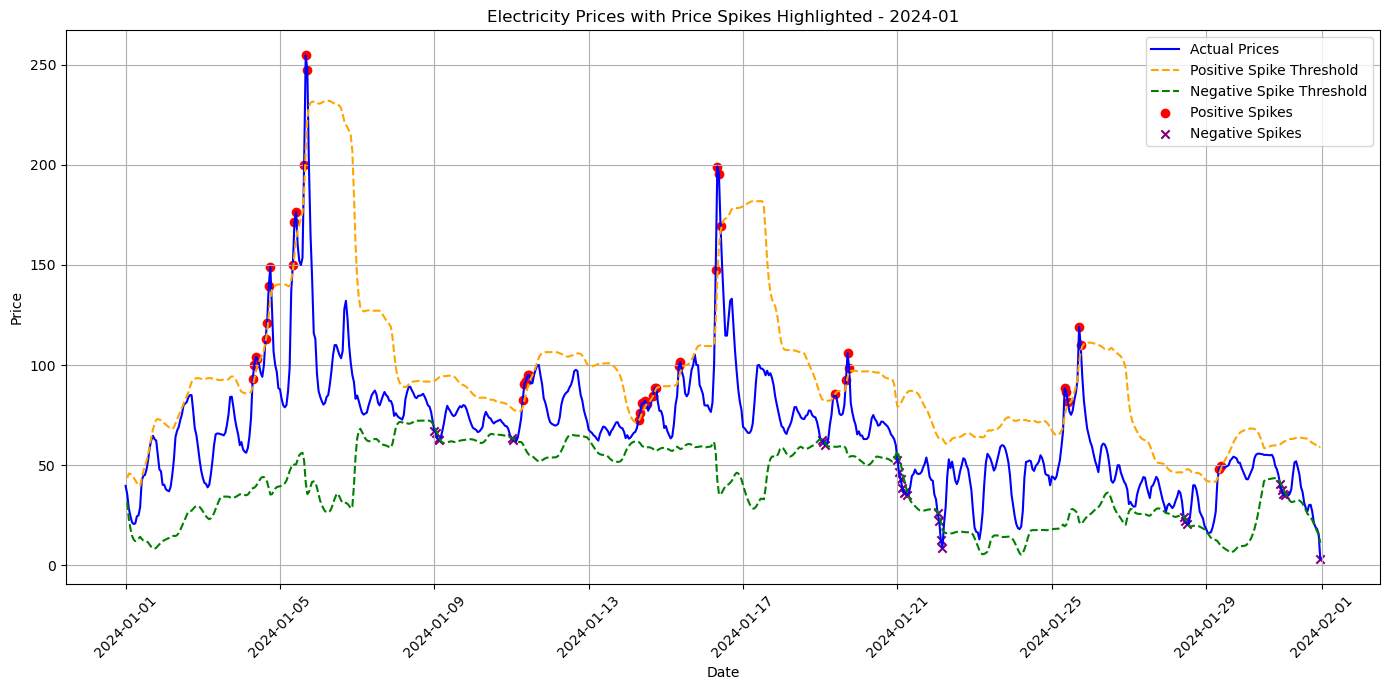

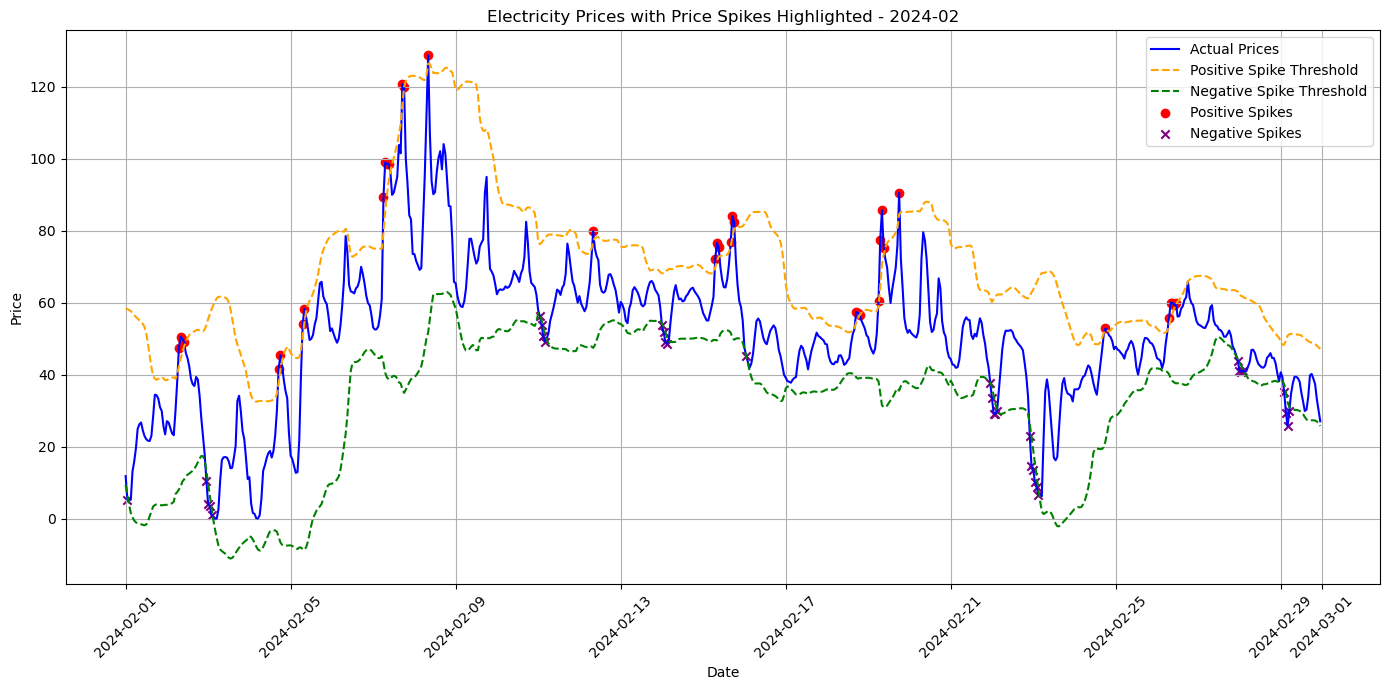

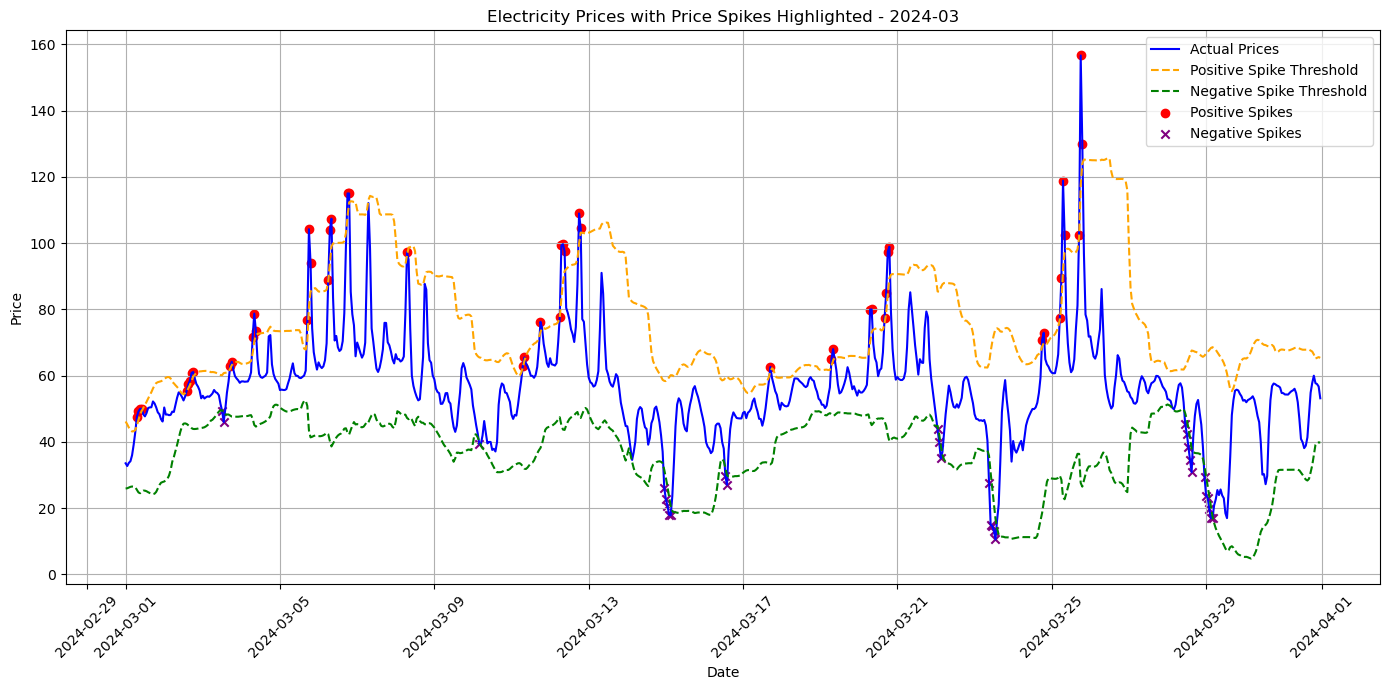

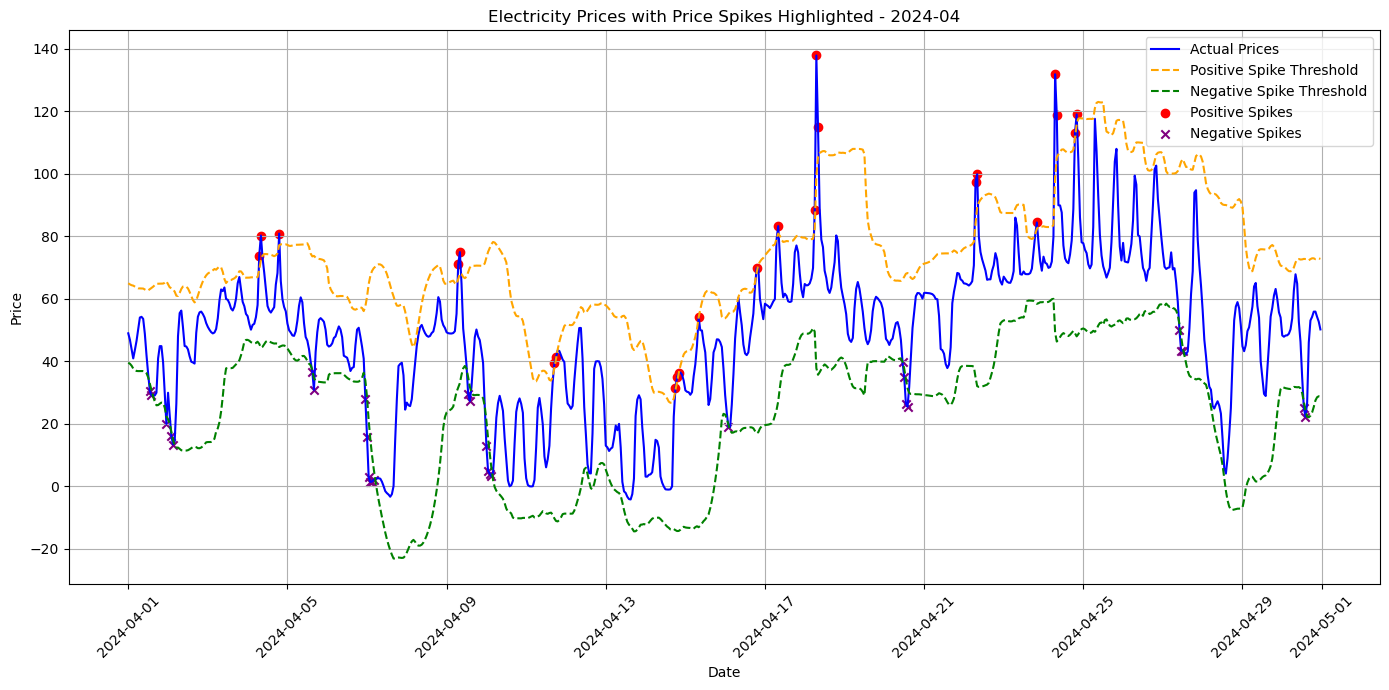

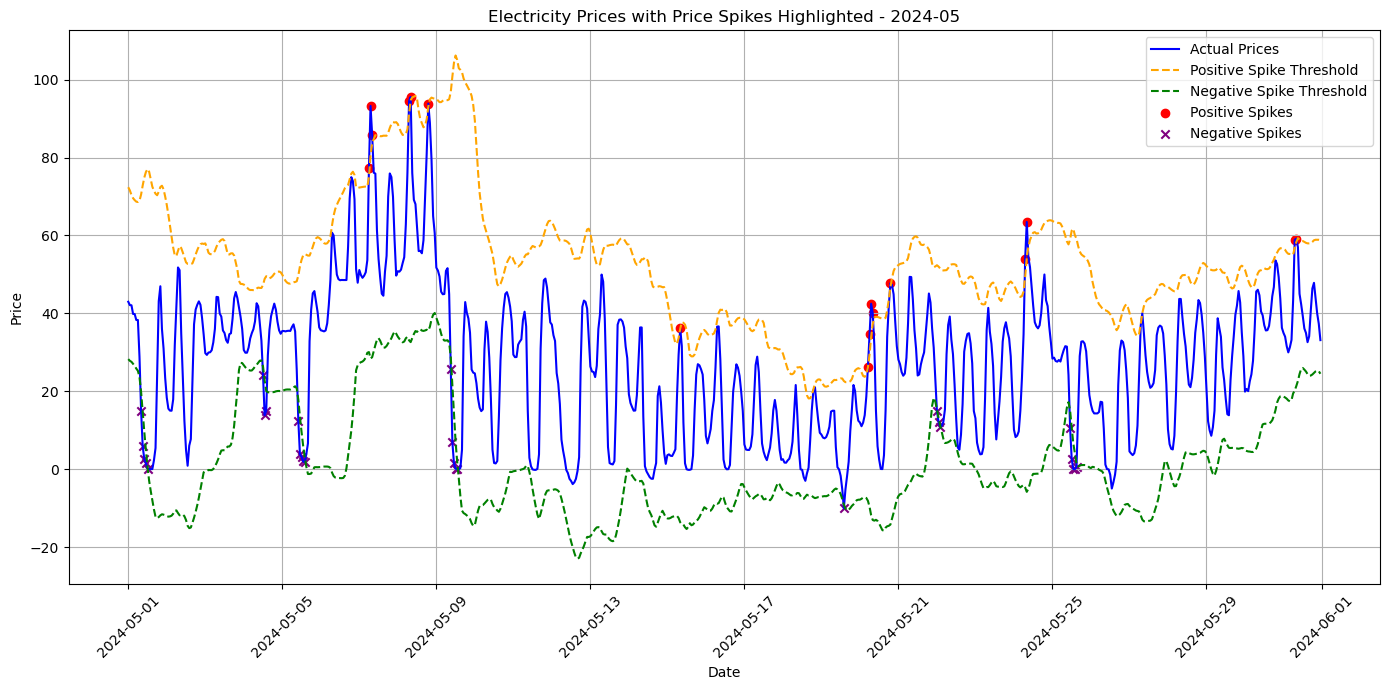

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

df.index = pd.to_datetime(df.index)

# Calculate the rolling mean and standard deviation with a window of 30 days
rolling_mean = df['Actual'].rolling(window=30, min_periods=1).mean()
rolling_std = df['Actual'].rolling(window=30, min_periods=1).std()

# Define dynamic thresholds for positive and negative price spikes
positive_spike_threshold = rolling_mean + 2 * rolling_std
negative_spike_threshold = rolling_mean - 2 * rolling_std

# Identify positive and negative price spikes
positive_price_spikes = df[df['Actual'] > positive_spike_threshold]
negative_price_spikes = df[df['Actual'] < negative_spike_threshold]

# Loop through each month and generate a plot
months = df.index.to_period('M').unique()

for month in months:
    monthly_data = df[df.index.to_period('M') == month]
    monthly_positive_spikes = positive_price_spikes[positive_price_spikes.index.to_period('M') == month]
    monthly_negative_spikes = negative_price_spikes[negative_price_spikes.index.to_period('M') == month]
    
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_data.index, monthly_data['Actual'], label='Actual Prices', color='blue')
    plt.plot(monthly_data.index, positive_spike_threshold[monthly_data.index], label='Positive Spike Threshold', color='orange', linestyle='--')
    plt.plot(monthly_data.index, negative_spike_threshold[monthly_data.index], label='Negative Spike Threshold', color='green', linestyle='--')
    plt.scatter(monthly_positive_spikes.index, monthly_positive_spikes['Actual'], color='red', label='Positive Spikes', marker='o')
    plt.scatter(monthly_negative_spikes.index, monthly_negative_spikes['Actual'], color='purple', label='Negative Spikes', marker='x')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Electricity Prices with Price Spikes Highlighted - {month}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()


In [27]:
# Identify positive and negative price spikes
positive_price_spikes = df[df['Actual'] > positive_spike_threshold]
negative_price_spikes = df[df['Actual'] < negative_spike_threshold]

# Initialize a dictionary to store the results for MLP and LSTM
spike_results = {
    'Model': [],
    'Overestimate Positive Spikes (%)': [],
    'Underestimate Positive Spikes (%)': [],
    'Overestimate Negative Spikes (%)': [],
    'Underestimate Negative Spikes (%)': []
}

# List of models to investigate
models_to_investigate = ['MLP Prediction', 'LSTM Prediction']

# Calculate overestimation and underestimation percentages for each model for positive spikes
for model in models_to_investigate:
    overestimates_positive = (positive_price_spikes[model] > positive_price_spikes['Actual']).sum()
    underestimates_positive = (positive_price_spikes[model] < positive_price_spikes['Actual']).sum()
    total_positive_spikes = len(positive_price_spikes)
    
    overestimate_positive_percentage = (overestimates_positive / total_positive_spikes) * 100
    underestimate_positive_percentage = (underestimates_positive / total_positive_spikes) * 100

    overestimates_negative = (negative_price_spikes[model] > negative_price_spikes['Actual']).sum()
    underestimates_negative = (negative_price_spikes[model] < negative_price_spikes['Actual']).sum()
    total_negative_spikes = len(negative_price_spikes)
    
    overestimate_negative_percentage = (overestimates_negative / total_negative_spikes) * 100
    underestimate_negative_percentage = (underestimates_negative / total_negative_spikes) * 100

    spike_results['Model'].append(model)
    spike_results['Overestimate Positive Spikes (%)'].append(overestimate_positive_percentage)
    spike_results['Underestimate Positive Spikes (%)'].append(underestimate_positive_percentage)
    spike_results['Overestimate Negative Spikes (%)'].append(overestimate_negative_percentage)
    spike_results['Underestimate Negative Spikes (%)'].append(underestimate_negative_percentage)

spike_results_df = pd.DataFrame(spike_results)
print(spike_results_df)


             Model  Overestimate Positive Spikes (%)  \
0   MLP Prediction                         34.117647   
1  LSTM Prediction                         42.352941   

   Underestimate Positive Spikes (%)  Overestimate Negative Spikes (%)  \
0                          65.882353                         67.123288   
1                          57.647059                         76.712329   

   Underestimate Negative Spikes (%)  
0                          32.876712  
1                          23.287671  


In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate RMSE and MAE
def calculate_error_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

# Initialize a dictionary to store the results for MLP and LSTM
spike_error_metrics = {
    'Model': [],
    'RMSE Positive Spikes': [],
    'MAE Positive Spikes': [],
    'RMSE Negative Spikes': [],
    'MAE Negative Spikes': []
}

# Calculate RMSE and MAE for each model for positive and negative spikes
for model in models_to_investigate:
    # Positive Spikes
    rmse_positive, mae_positive = calculate_error_metrics(positive_price_spikes['Actual'], positive_price_spikes[model])
    
    # Negative Spikes
    rmse_negative, mae_negative = calculate_error_metrics(negative_price_spikes['Actual'], negative_price_spikes[model])
    
    spike_error_metrics['Model'].append(model)
    spike_error_metrics['RMSE Positive Spikes'].append(rmse_positive)
    spike_error_metrics['MAE Positive Spikes'].append(mae_positive)
    spike_error_metrics['RMSE Negative Spikes'].append(rmse_negative)
    spike_error_metrics['MAE Negative Spikes'].append(mae_negative)

spike_error_metrics_df = pd.DataFrame(spike_error_metrics)
print(spike_error_metrics_df)


             Model  RMSE Positive Spikes  MAE Positive Spikes  \
0   MLP Prediction              9.216675             5.635553   
1  LSTM Prediction             14.645304             9.413646   

   RMSE Negative Spikes  MAE Negative Spikes  
0              4.501835             3.392141  
1              6.446832             5.072019  


## Direction of price 

In [32]:

direction_accuracy = {
    'Model': [],
    'Correct Direction (%)': []
}

for model in models_to_investigate:
    correct_direction = ((df['Actual'].diff() * df[model].diff()) > 0).sum()
    total_direction_changes = len(df) - 1  
    accuracy_percentage = (correct_direction / total_direction_changes) * 100

    direction_accuracy['Model'].append(model)
    direction_accuracy['Correct Direction (%)'].append(accuracy_percentage)

direction_accuracy_df = pd.DataFrame(direction_accuracy)
print(direction_accuracy_df)


             Model  Correct Direction (%)
0   MLP Prediction              89.306279
1  LSTM Prediction              77.680285


In [33]:
import pandas as pd

direction_accuracy = {
    'Model': [],
    'Correct Upward Change (%)': [],
    'Correct Downward Change (%)': [],
    'Overall Correct Direction (%)': []
}

models_to_investigate = ['MLP Prediction', 'LSTM Prediction']

for model in models_to_investigate:
    actual_diff = df['Actual'].diff()
    model_diff = df[model].diff()
    
    # Upward changes
    correct_upward_changes = ((actual_diff > 0) & (model_diff > 0)).sum()
    total_upward_changes = (actual_diff > 0).sum()
    upward_accuracy_percentage = (correct_upward_changes / total_upward_changes) * 100 if total_upward_changes > 0 else 0
    
    # Downward changes
    correct_downward_changes = ((actual_diff < 0) & (model_diff < 0)).sum()
    total_downward_changes = (actual_diff < 0).sum()
    downward_accuracy_percentage = (correct_downward_changes / total_downward_changes) * 100 if total_downward_changes > 0 else 0
    
    # Overall direction accuracy
    correct_direction = ((actual_diff * model_diff) > 0).sum()
    total_direction_changes = len(df) - 1  
    overall_accuracy_percentage = (correct_direction / total_direction_changes) * 100

    direction_accuracy['Model'].append(model)
    direction_accuracy['Correct Upward Change (%)'].append(upward_accuracy_percentage)
    direction_accuracy['Correct Downward Change (%)'].append(downward_accuracy_percentage)
    direction_accuracy['Overall Correct Direction (%)'].append(overall_accuracy_percentage)

direction_accuracy_df = pd.DataFrame(direction_accuracy)
print(direction_accuracy_df)


             Model  Correct Upward Change (%)  Correct Downward Change (%)  \
0   MLP Prediction                  89.407314                    89.970646   
1  LSTM Prediction                  82.660782                    74.461840   

   Overall Correct Direction (%)  
0                      89.306279  
1                      77.680285  
